In [53]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" 

print(HOUSING_PATH)

datasets\housing


# 1. Get the data and take a look at it

In [54]:
#download and extract a compressed data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close


In [55]:
import pandas as pd
# load data into a dataframe
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [56]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [57]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [58]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [59]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


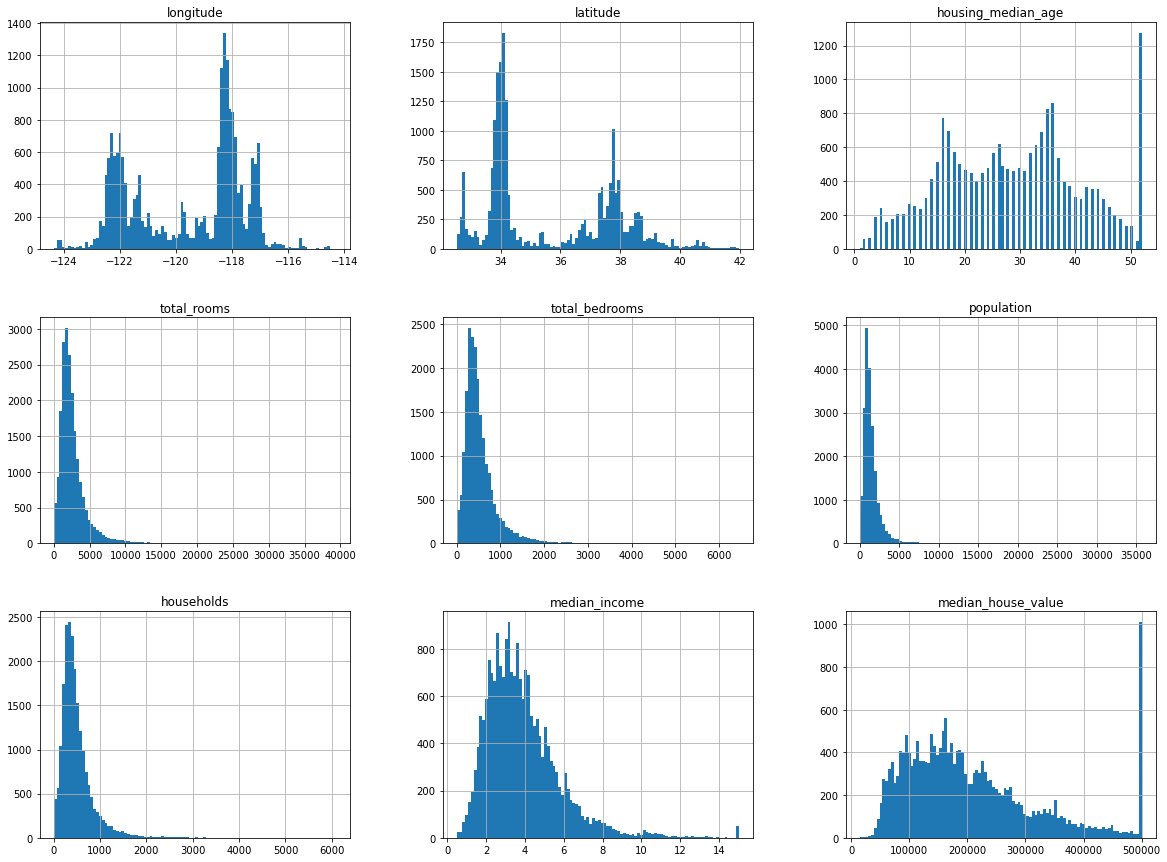

In [60]:
import matplotlib.pyplot as plt
housing.hist(bins=100, figsize=(20,15))
plt.show()

In [61]:
from zlib import crc32
import numpy as np

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 **32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # add an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')



In [62]:
#split by a built-in function from sklearn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [63]:
#if the median income is an important attribute, we should split the train/test data following the ratio in the value of media_income
housing["income_cat"] = pd.cut(housing["median_income"], 
                                       bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                                       labels = [1, 2, 3, 4, 5]) 
#housing["income_cat"].hist()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))
#print(strat_train_set["income_cat"].value_counts()/len(strat_train_set))
#print(housing["income_cat"].value_counts()/len(housing))

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


# 2. Discover and Visualize the Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

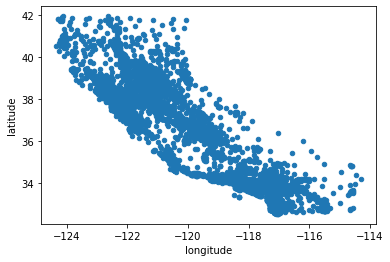

In [64]:
housing.plot(kind='scatter', x='longitude', y='latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

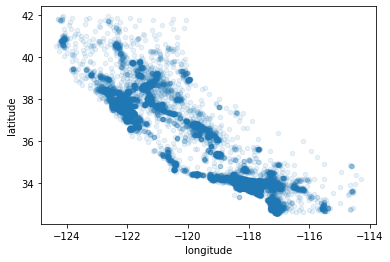

In [65]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

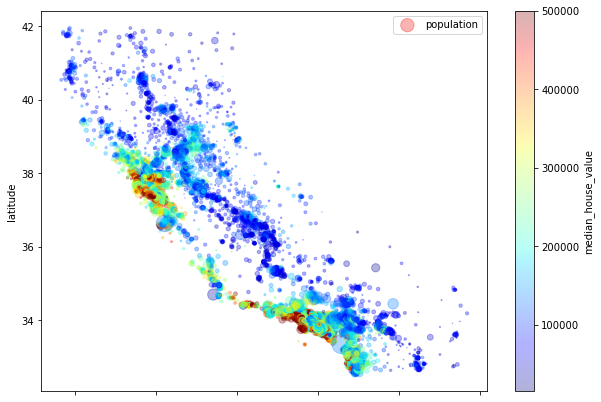

In [66]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True
            )

In [67]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [68]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

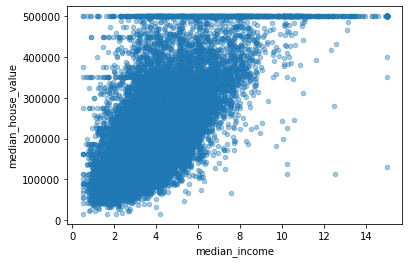

In [69]:
#Median income have the most correlation with the median house value, we plot a scatter plot to see more
housing.plot(kind='scatter', y='median_house_value',x='median_income',alpha=0.4)

In [70]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [71]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

# 3. Prepare the Data for Machine Learning Algorithms

In [72]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 3.1 Data Cleaning

In [73]:
# Set the missing values of total_bedrooms column of training set to their median value
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace=True)

In [74]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [75]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index=housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### 3.2 Handling text data

In [76]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [77]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 3.3 Custom Transformers

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

#total rooms, total bedrooms, population, households
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or *kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [79]:
housing_extra_attribs[1]

array([-117.23, 33.09, 7.0, 5320.0, 855.0, 2015.0, 768.0, 6.3373,
       'NEAR OCEAN', 6.927083333333333, 2.6236979166666665], dtype=object)

### 3.4 Transformation Pipelines

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [81]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[1]

array([ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
        0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
       -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ])

# 4. Select and Train a Model

### 4.1 Training and Evaluating on the Training Set

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [83]:
# Let's try it out on a few instances from the training set
some_data = housing.iloc[25:30]
some_labels = housing_labels.iloc[25:30]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 67444.06149134 292359.15106592 193693.73093998 226518.08766582
 270834.03993152]
Labels: [85900.0, 238100.0, 173500.0, 196100.0, 442900.0]


In [84]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [85]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


0.0

### 4.2 Better Evaluation Using Cross-Validation

In [86]:
#Using K-fold cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [87]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72903.34460034 71004.42157933 67403.14335689 70236.42496201
 70094.12580235 77072.88467866 71122.66180575 74273.96882234
 69610.66160792 70154.14695761]
Mean: 71387.57841731966
Standard deviation: 2583.044272938464


In [88]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18747.212661769634

In [89]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [51490.21192252 49184.92605454 47245.50400764 51651.25820652
 47490.55812407 51838.71912246 52126.3429129  49876.14446474
 48439.90927276 53814.02929153]
Mean: 50315.76033796843
Standard deviation: 2083.206578029303


# 5. Fine-Tune the Model

### 5.1 Grid-Search

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ] 

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [91]:
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64290.85686719424 {'max_features': 2, 'n_estimators': 3}
55456.72731787417 {'max_features': 2, 'n_estimators': 10}
52856.14418480841 {'max_features': 2, 'n_estimators': 30}
60046.34916689895 {'max_features': 4, 'n_estimators': 3}
53084.40291392452 {'max_features': 4, 'n_estimators': 10}
50151.8591923443 {'max_features': 4, 'n_estimators': 30}
58771.76502411855 {'max_features': 6, 'n_estimators': 3}
52102.82697615712 {'max_features': 6, 'n_estimators': 10}
50150.848632513844 {'max_features': 6, 'n_estimators': 30}
58713.91679253343 {'max_features': 8, 'n_estimators': 3}
52350.70437326392 {'max_features': 8, 'n_estimators': 10}
50036.85710329808 {'max_features': 8, 'n_estimators': 30}
62824.73111808112 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54003.92978485701 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60060.90147439541 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52295.40880468231 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

### 5.2 Analyze the Best Models and Their Errors

In [92]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.88454224e-02, 6.42658802e-02, 4.06925943e-02, 1.56274229e-02,
       1.43608011e-02, 1.44409141e-02, 1.39076452e-02, 3.25398518e-01,
       6.12106302e-02, 1.17571175e-01, 7.45140917e-02, 6.29753789e-03,
       1.78449336e-01, 9.02305636e-05, 1.70932227e-03, 2.61847820e-03])

In [93]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32539851791991486, 'median_income'),
 (0.17844933639889268, 'INLAND'),
 (0.11757117467105781, 'pop_per_hhold'),
 (0.0745140917137754, 'bedrooms_per_room'),
 (0.06884542236125564, 'longitude'),
 (0.06426588023799291, 'latitude'),
 (0.061210630183510764, 'rooms_per_hhold'),
 (0.04069259427880849, 'housing_median_age'),
 (0.015627422927727716, 'total_rooms'),
 (0.014440914098046516, 'population'),
 (0.014360801057400249, 'total_bedrooms'),
 (0.01390764522521876, 'households'),
 (0.006297537891987405, '<1H OCEAN'),
 (0.0026184782004319207, 'NEAR OCEAN'),
 (0.0017093222703814625, 'NEAR BAY'),
 (9.023056359738421e-05, 'ISLAND')]

### 5.3 Evaluate the System on the Test Set

In [97]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 

In [100]:
from scipy import stats
confidance = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidance, len(squared_errors)-1, 
                       loc=squared_errors.mean(),
                       scale=stats.sem(squared_errors))
                       )

array([45722.33674112, 49637.37111762])